In [1]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
!pip install hydroeval
!pip install SGD


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_csv('final.csv')
df.head()

,Date,basantpur_rainfall,Andhiyarkhore,Bamnidhi,Simga,Ghatora,Rajim,Rampur,Basantpur
0,01-07-2001,21.944357,5.400,1350.000,35.00,150.000,160.000,108.000,2250.000
1,02-07-2001,3.318059,4.078,496.334,97.25,78.000,150.366,119.859,1353.260
2,03-07-2001,2.335704,3.071,163.761,105.40,35.327,62.633,68.933,1145.230
3,04-07-2001,7.705987,2.343,156.041,67.31,21.230,36.257,48.694,676.221
4,05-07-2001,31.771525,2.321,148.249,48.46,22.491,29.935,23.432,646.760


In [3]:
cols=list(df)[1:9]
data=df[cols].astype(float)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

In [5]:
#converts col into different array
R,Qa,Qbi,Qs,Qg,Qr,Qrm,Qb =scaled_data.T

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [7]:
#Is = series_to_supervised(I,4,2)
R = series_to_supervised(R,3,1)
Qas = series_to_supervised(Qa,3,1)
Qbis= series_to_supervised(Qbi,3,1)
Qss = series_to_supervised(Qs,3,1)
Qgs = series_to_supervised(Qg,3,1)
Qrs = series_to_supervised(Qr,3,1)
Qrms = series_to_supervised(Qrm,3,1)
Qbs = series_to_supervised(Qb,3,2)
#Rs = series_to_supervised(R,1,1)

In [8]:
dfs=[R,Qas,Qbis,Qss,Qgs,Qrs,Qrms,Qbs]
Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
Input = Input.iloc[3-0:] #change iloc only if u cange lag days
Input = Input.drop(Input.index[-1:])

In [9]:
Input

,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t-3)2,var(t-2)2,var(t-1)2,var(t)2,var(t-3)3,var(t-2)3,...,var(t)6,var(t-3)7,var(t-2)7,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8,var(t+1)8
6,0.081014,0.334020,0.308209,0.182478,0.003978,0.003941,0.006606,0.020403,0.018960,0.017951,...,0.124113,0.004401,0.002095,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854,0.039174
7,0.334020,0.308209,0.182478,0.241542,0.003941,0.006606,0.020403,0.011954,0.017951,0.021439,...,0.100364,0.002095,0.002460,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174,0.129853
8,0.308209,0.182478,0.241542,0.409743,0.006606,0.020403,0.011954,0.048305,0.021439,0.052034,...,0.844190,0.002460,0.007934,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853,0.473977
9,0.182478,0.241542,0.409743,0.187636,0.020403,0.011954,0.048305,0.069608,0.052034,0.031128,...,0.414098,0.007934,0.031897,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977,0.302142
10,0.241542,0.409743,0.187636,0.253682,0.011954,0.048305,0.069608,0.039898,0.031128,0.032914,...,0.141782,0.031897,0.126150,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142,0.144966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.026240,0.048115,0.145416,0.049192,0.053647,0.026902,0.021112,0.018255,0.031069,0.036486,...,0.017562,0.024851,0.015539,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635,0.055443
1007,0.048115,0.145416,0.049192,0.007834,0.026902,0.021112,0.018255,0.018253,0.036486,0.052095,...,0.017530,0.015539,0.020225,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443,0.048120
1008,0.145416,0.049192,0.007834,0.000533,0.021112,0.018255,0.018253,0.014383,0.052095,0.050553,...,0.019187,0.020225,0.013163,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120,0.028554
1009,0.049192,0.007834,0.000533,0.000100,0.018255,0.018253,0.014383,0.013407,0.050553,0.043512,...,0.017202,0.013163,0.013151,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554,0.023694


In [10]:
y=Input[Input.columns[Input.columns.isin(['var(t+1)8'])]]

In [11]:
y

,var(t+1)8
6,0.039174
7,0.129853
8,0.473977
9,0.302142
10,0.144966
...,...
1006,0.055443
1007,0.048120
1008,0.028554
1009,0.023694


In [12]:
x=Input.drop(['var(t+1)8'],axis=1)

In [13]:
x

,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t-3)2,var(t-2)2,var(t-1)2,var(t)2,var(t-3)3,var(t-2)3,...,var(t-1)6,var(t)6,var(t-3)7,var(t-2)7,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8
6,0.081014,0.334020,0.308209,0.182478,0.003978,0.003941,0.006606,0.020403,0.018960,0.017951,...,0.011465,0.124113,0.004401,0.002095,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854
7,0.334020,0.308209,0.182478,0.241542,0.003941,0.006606,0.020403,0.011954,0.017951,0.021439,...,0.124113,0.100364,0.002095,0.002460,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174
8,0.308209,0.182478,0.241542,0.409743,0.006606,0.020403,0.011954,0.048305,0.021439,0.052034,...,0.100364,0.844190,0.002460,0.007934,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853
9,0.182478,0.241542,0.409743,0.187636,0.020403,0.011954,0.048305,0.069608,0.052034,0.031128,...,0.844190,0.414098,0.007934,0.031897,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977
10,0.241542,0.409743,0.187636,0.253682,0.011954,0.048305,0.069608,0.039898,0.031128,0.032914,...,0.414098,0.141782,0.031897,0.126150,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.026240,0.048115,0.145416,0.049192,0.053647,0.026902,0.021112,0.018255,0.031069,0.036486,...,0.027269,0.017562,0.024851,0.015539,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635
1007,0.048115,0.145416,0.049192,0.007834,0.026902,0.021112,0.018255,0.018253,0.036486,0.052095,...,0.017562,0.017530,0.015539,0.020225,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443
1008,0.145416,0.049192,0.007834,0.000533,0.021112,0.018255,0.018253,0.014383,0.052095,0.050553,...,0.017530,0.019187,0.020225,0.013163,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120
1009,0.049192,0.007834,0.000533,0.000100,0.018255,0.018253,0.014383,0.013407,0.050553,0.043512,...,0.019187,0.017202,0.013163,0.013151,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554


In [14]:
x_train=x[:456]
x_val=x[456:639]
x_test=x[639:]
y_train=y[:456]
y_val=y[456:639]
y_test=y[639:]

In [15]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape,x_val.shape,y_val.shape

((456, 32), (366, 32), (456, 1), (366, 1), (183, 32), (183, 1))

In [16]:
#converting dataframe to array to reshape in next step
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values
x_val=x_val.values
y_val=y_val.values

In [17]:
#reshape into 3-D cz model cannot perform in 2-D
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

In [18]:
x_train.shape

(456, 1, 32)

In [19]:
from keras.layers import Dense, Flatten, Dropout, MaxPooling1D, TimeDistributed, LSTM, BatchNormalization, Input, concatenate, Conv1D


model=Sequential()
model.add(Conv1D(filters=64, kernel_size=2, padding = "same", strides = 1, activation = "relu",input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Conv1D(filters=50, kernel_size=2, padding = "same", strides = 1, activation = "relu"))
#model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Flatten()))
model.add(LSTM(50,activation = "relu",return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer = "adam",loss = "mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             4160      
                                                                 
 lstm (LSTM)                 (None, 1, 50)             23000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 47,411
Trainable params: 47,411
Non-trainable params: 0
_________________________________________________________________


In [20]:
 # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
history = model.fit(x_train.reshape(len(x_train), 1, x_train.shape[2], 1) ,y_train, batch_size=128, epochs=200, verbose=1,validation_data=(x_val, y_val))

Epoch 1/200
4/4 [==============================] - 4s 271ms/step - loss: 0.0113 - val_loss: 0.0091
Epoch 2/200
4/4 [==============================] - 0s 36ms/step - loss: 0.0091 - val_loss: 0.0070
Epoch 3/200
4/4 [==============================] - 0s 24ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 4/200
4/4 [==============================] - 0s 20ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 5/200
4/4 [==============================] - 0s 25ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 6/200
4/4 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 7/200
4/4 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 8/200
4/4 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 9/200
4/4 [==============================] - 0s 21ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 10/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 11/200
4/4 [

In [21]:

hist_df = pd.DataFrame(history.history)
hist_df

,loss,val_loss
0,0.011284,0.009064
1,0.009087,0.006975
2,0.007651,0.005438
3,0.006617,0.004565
4,0.006143,0.004255
...,...,...
195,0.000057,0.001818
196,0.000055,0.001809
197,0.000057,0.001790
198,0.000054,0.001816


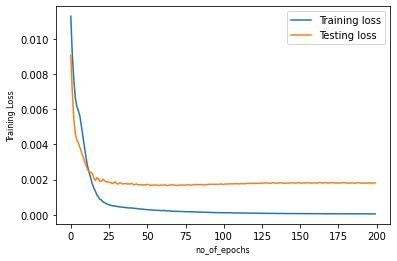

In [22]:
plt.plot(history.history['loss'],label='Training loss' )
plt.plot(history.history['val_loss'], label='Testing loss')
plt.xlabel('no_of_epochs', fontsize=8 )
plt.ylabel('Training Loss', fontsize=8 )
plt.legend()

In [23]:
train_yp = model.predict(x_train.reshape(len(x_train),1, x_train.shape[2],1))
val_yp = model.predict(x_val.reshape(len(x_val),1, x_val.shape[2], 1))
test_yp = model.predict(x_test.reshape(len(x_test),1, x_test.shape[2],1))
train_yp = model.predict(x_train)
val_yp = model.predict(x_val)
test_yp = model.predict(x_test)

12/12 [==============================] - 0s 2ms/step


In [24]:

train_yp.shape

(456, 1)

In [25]:
test_yp.shape

(366, 1)

In [26]:
x_train.shape

(456, 1, 32)

In [27]:
#reshape into the origional form (2-D)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
x_val= x_val.reshape((x_val.shape[0],x_val.shape[2]))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[2]))

In [28]:
#inverse_transform
#1)x_train
inv_x_train=pd.concat([pd.DataFrame(train_yp),pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_train) 
y_train_prediction=rev_trans[:,0]

#y_train
inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_train) 
y_train_Observed=rev_trans[:,0]

#x_test
inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_test) 
y_test_prediction=rev_trans[:,0]

#y_test
inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_test) 
y_test_Observed=rev_trans[:,0]

# x_val
inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_val) 
y_val_prediction=rev_trans[:,0]

#y_val
inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_val) 
y_val_Observed=rev_trans[:,0]


In [29]:
y_train_pre=np.array(y_train_prediction)
y_train_rev=np.array(y_train_Observed)
l=np.array([y_train_prediction,y_train_Observed])
dataset=pd.DataFrame(l)
dataset=dataset.transpose()
dataset.columns = ['y_train_prediction', 'y_train_Observed']

In [30]:
dataset

,y_train_prediction,y_train_Observed
0,4.509215,3.726210
1,11.236666,12.351425
2,44.661254,45.084113
3,28.557836,28.739332
4,13.467443,13.788960
...,...,...
451,2.026236,2.079410
452,1.822683,2.046269
453,1.716774,0.394555
454,1.570069,0.189873


<Axes: >

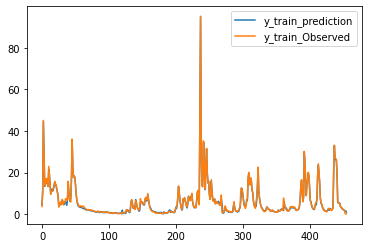

In [31]:
dataset[['y_train_prediction','y_train_Observed']].plot()

In [32]:
from hydroeval import evaluator, nse

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
print(NSE_train)

[0.99318799]


<Axes: >

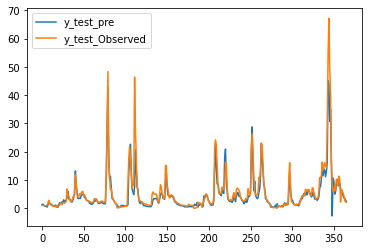

In [33]:
#test
y_test_pre=np.array(y_test_prediction)
y_test_Observed=np.array(y_test_Observed)
l=np.array([y_test_prediction,y_test_Observed])
dataset_test=pd.DataFrame(l)
dataset_test=dataset_test.transpose()
dataset_test.columns = ['y_test_pre', 'y_test_Observed']
dataset_test[['y_test_pre','y_test_Observed']].plot()

In [34]:
NSE_test = evaluator(nse,y_test_pre , y_test_Observed )
print(NSE_test)

[0.82739518]


<Axes: >

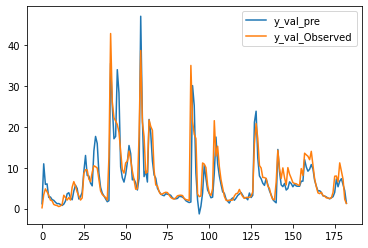

In [35]:
y_val_pre=np.array(y_val_prediction)
y_val_Observed=np.array(y_val_Observed)
l=np.array([y_val_prediction,y_val_Observed])
dataset_val=pd.DataFrame(l)
dataset_val=dataset_val.transpose()
dataset_val.columns = ['y_val_pre', 'y_val_Observed']
dataset_val[['y_val_pre','y_val_Observed']].plot()

In [36]:
NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
print(NSE_val)

[0.64706881]


In [37]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
np.random.seed(2020)
from hydroeval import evaluator,nse,kge,kgeprime,rmse,mare,pbias

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
NSE_test = evaluator(nse,y_test_pre , y_test_Observed )

RMSE_Training =evaluator(rmse,y_train_prediction , y_train_Observed)
RMSE_val = evaluator(rmse,y_val_pre, y_val_Observed)
RMSE_Testing = evaluator(rmse,y_test_pre , y_test_Observed)


MARE_Training =evaluator(mare,y_train_pre,y_train_Observed)
MARE_val = evaluator(mare,y_val_pre, y_val_Observed)
MARE_Testing = evaluator(mare,y_test_pre , y_test_Observed)
    
    
PBIAS_Training =evaluator(pbias,y_train_pre ,y_train_Observed)
PBIAS_val = evaluator(pbias,y_val_pre, y_val_Observed)
PBIAS_Testing = evaluator(pbias,y_test_pre , y_test_Observed)
    
    
# corr_train ,p_value_train = pearsonr(y_train_pre, y_train_Observed)
# corr_test ,p_value_test = pearsonr(y_test_pre,  y_test_Observed)
    
        
# mae_train = mean_absolute_error(y_train_Observed, y_train_pre) 
# mae_test = mean_absolute_error( y_test_Observed,y_test_pre) 
    
v_error_train = (np.sum(y_train_pre)-np.sum(y_train_Observed))/np.sum(y_train_Observed)
v_error_val  = (np.sum(y_val_pre)-np.sum(y_val_Observed))/np.sum(y_val_Observed) 
v_error_test  = (np.sum(y_test_pre)-np.sum(y_test_Observed))/np.sum(y_test_Observed)  

In [38]:
results=[NSE_train,NSE_val,NSE_test,RMSE_Training,RMSE_val,RMSE_Testing, MARE_Training,MARE_val,MARE_Testing, PBIAS_Training,PBIAS_val,PBIAS_Testing,v_error_train,v_error_val,v_error_test]
l=np.array([results])
res=pd.DataFrame(l).transpose()
res

<ipython-input-38-dd8356cd6518>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  l=np.array([results])


,0
0,[0.9931879855527523]
1,[0.6470688052260593]
2,[0.8273951811072209]
3,[0.6797203698909118]
4,[4.047853478250441]
5,[3.286301374952631]
6,[0.06605829138380413]
7,[0.2763434231959072]
8,[0.25038821240913606]
9,[1.742707291809724]


In [39]:
#res.to_csv(r'D:\iitkgp\saa\cnn_lstm_1.csv')

In [40]:
batch_size = [256]
epochs = [200]
optimizer_ = ['adam','sgd','rmsprop','adgrad','adadelta','adamax','nadam','tfoptimizer']
loss_ = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error','cosine_similarity','huber_loss','log_cosh']
activation_ = ['sigmoid','relu','softmax','softplus','softsign','tanh','selu','elu','exponential']
units_ = [100]
param_grid = dict(units=units_,batch_size=batch_size,epochs=epochs,activation = activation_,optimizer = optimizer_,loss = loss_)
param_grid

{'units': [100],
 'batch_size': [256],
 'epochs': [200],
 'activation': ['sigmoid',
  'relu',
  'softmax',
  'softplus',
  'softsign',
  'tanh',
  'selu',
  'elu',
  'exponential'],
 'optimizer': ['adam',
  'sgd',
  'rmsprop',
  'adgrad',
  'adadelta',
  'adamax',
  'nadam',
  'tfoptimizer'],
 'loss': ['mean_squared_error',
  'mean_absolute_error',
  'mean_absolute_percentage_error',
  'mean_squared_logarithmic_error',
  'cosine_similarity',
  'huber_loss',
  'log_cosh']}

In [41]:
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [42]:
#reshape into 3-D cz model cannot perform in 2-D
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
#x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

In [ ]:
def LSTM_Model(activation = 'sigmoid',loss = 'mse',optimizer = 'adam',units = 50):
    model=Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, padding = "same", strides = 1, activation = activation,input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units = units,activation = activation,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer = optimizer,loss = loss)
    return model



model = KerasRegressor(build_fn=LSTM_Model, verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring = "r2")

grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


# storing all the results in dataframe

df = pd.DataFrame(grid.cv_results_)
df = df[['mean_fit_time', 'param_activation', 'param_batch_size', 'param_epochs', 'param_loss', 'param_optimizer', 'param_units', 'mean_test_score', 'rank_test_score']]
        
df.sort_values(by='rank_test_score', inplace=True)
df

In [ ]:
#getting keys from cv_results

grid.cv_results_.keys()

# storing all the results in dataframe

df = pd.DataFrame(grid.cv_results_)
df = df[['mean_fit_time', 'param_activation', 'param_batch_size', 'param_epochs', 'param_loss', 'param_optimizer', 'param_units', 'mean_test_score', 'rank_test_score']]
        
df.sort_values(by='rank_test_score', inplace=True)
df